In [2]:
import pandas_gbq
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
import folium
from datetime import datetime
from folium.plugins import MarkerCluster
from folium.map import Icon

In [3]:
plt.rcParams["figure.figsize"] = (40, 20)
plt.rcParams["font.size"] = 32

In [95]:
query = '''
select 
    id
    , identity.url
    , identity.download_data as scraped_at
    , geography.gps.lat as lat
    , geography.gps.lon as lon
    , round(ST_DISTANCE(ST_GEOGPOINT(geography.gps.lon, geography.gps.lat), ST_GEOGPOINT({lon}, {lat})), 2) as distance
    , geography.address.city as city
    , geography.address.municipality as municipality
    , area.internal.sqm as sqm
    , price.amount as asking_price
    , features.type_of as property_type
    , features.living_room_no as tot_number_of_livable_rooms
    , features.bath_room_no as tot_number_of_bathrooms
    , last_seen
    , is_gone
    , has_new_entry
    , TIMESTAMP_DIFF(last_seen, identity.download_data, DAY) as time_on_market

from `viper-uk.data_it.data_asking` asking
    join `viper-uk.data_it.missing_props` mp on asking.identity.url = mp.url
where 
    last_seen > "2020-01-01 00:00:00 UTC"
    and ST_DISTANCE(ST_GEOGPOINT(geography.gps.lon, geography.gps.lat), ST_GEOGPOINT({lon}, {lat})) < {radius}
'''

In [96]:
main_location = {"lat": "45.553951", "lon": "8.966671"}
search_radius = 1000

In [97]:
df = pandas_gbq.read_gbq(query.format(lat=main_location["lat"], lon=main_location["lon"], radius=search_radius), project_id="viper-uk")

In [99]:
df['age_in_days'] = (datetime.now().date() - df.scraped_at.dt.date).dt.days

0      3
1      3
2      3
3      3
4     94
      ..
82    14
83    14
84    14
85    14
86    14
Name: scraped_at, Length: 87, dtype: int64

In [100]:
df

,id,url,scraped_at,lat,lon,distance,city,municipality,sqm,asking_price,property_type,tot_number_of_livable_rooms,tot_number_of_bathrooms,last_seen,is_gone,has_new_entry,time_on_market
0,NaN,https://www.casa.it/appartamento/vendita/milan...,2020-02-02 22:33:01.636117+00:00,45.556587,8.978088,3928.55,Nerviano,Milano,60.0,77000.0,Appartamento,2,1,2020-01-31 12:40:02.729891+00:00,False,None,-2
1,38766804.0,https://www.casa.it/appartamento/vendita/milan...,2020-02-02 22:33:01.636117+00:00,45.556587,8.978088,3928.55,Nerviano,Milano,60.0,77000.0,Appartamento,2,1,2020-02-02 22:33:01.636117+00:00,False,True,0
2,38554644.0,https://www.casa.it/appartamento/vendita/milan...,2020-02-02 22:31:33.245058+00:00,45.555617,8.975658,3919.62,Nerviano,Milano,85.0,95000.0,Appartamento,3,1,2020-02-02 22:31:33.245058+00:00,False,True,0
3,38460384.0,https://www.casa.it/appartamento/vendita/milan...,2020-02-02 22:40:54.091646+00:00,45.551680,8.970550,4134.21,Nerviano,Milano,78.0,42750.0,Appartamento,3,1,2020-02-02 22:40:54.091646+00:00,False,True,0
4,73528644.0,https://www.immobiliare.it/annunci/73528644/,2019-11-03 06:17:33.116231+00:00,45.552500,8.971600,4082.95,,Nerviano,122.0,153000.0,Apartment,3,3,2020-02-02 02:17:32.176667+00:00,False,True,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,NaN,https://www.casa.it/appartamento/vendita/milan...,2020-01-22 01:59:42.391094+00:00,45.549417,8.971743,4402.24,Nerviano,Milano,90.0,165000.0,Appartamento,3,1,2020-01-31 12:40:02.729891+00:00,False,None,9
83,NaN,https://www.casa.it/villa/vendita/milano/local...,2020-01-22 02:01:07.925806+00:00,45.548940,8.975150,4558.14,Nerviano,Milano,141.0,77760.0,Villa,5,1,2020-01-31 12:40:02.729891+00:00,False,None,9
84,36452135.0,https://www.casa.it/villa/vendita/milano/local...,2020-01-22 02:01:07.925806+00:00,45.548940,8.975150,4558.14,Nerviano,Milano,141.0,77760.0,Villa,5,1,2020-01-22 02:01:07.925806+00:00,False,True,0
85,NaN,https://www.casa.it/villa/vendita/milano/local...,2020-01-22 02:06:28.181214+00:00,45.548940,8.975150,4558.14,Nerviano,Milano,141.0,77760.0,Villa,5,1,2020-01-31 12:40:02.729891+00:00,False,None,9


In [24]:
some_map = folium.Map(location=[main_location['lat'], main_location['lon']], 
                      zoom_start=14,
                     tiles='CartoDB positron')

mc = MarkerCluster()

#creating a Marker for each point in df_sample. Each point will get a popup with their zip
for index, row in df.iterrows():
    mc.add_child(folium.Marker(location=[row.lat,  row.lon],
                               popup="{}: {}-{}".format(row.name, row.lat,  row.lon),
                               tooltip = "Comparable"
                              ))

mc.add_child(folium.Marker(location=[main_location['lat'], main_location['lon']],
                           popup="{}: {}-{}".format("Asset", main_location['lat'], main_location['lon']),
                           tooltip = "Asset", 
                           icon=Icon(color='red', icon_color='black')
                          ))
some_map.add_child(mc)
folium.Circle([main_location['lat'], main_location['lon']], radius=search_radius).add_to(some_map)
folium.LayerControl().add_to(some_map)
some_map

In [101]:
df_sold = df[df.is_gone]
df_on_sale = df[np.logical_not(df.is_gone)]

In [110]:
plt.rcParams["figure.figsize"] = (40, 20)

base_map = folium.Map(location=[main_location['lat'], main_location['lon']], 
                      zoom_start=14,
                     tiles='CartoDB positron')


#creating a Marker for each sold property
for index, row in df_sold.iterrows():
    folium.Marker(location=[row.lat,  row.lon],
                  popup="{}: {} \nsqm: {}\nasking price: {}".format(row.name, row.property_type,  row.sqm, row.asking_price),
                  tooltip = "Comparable (sold)"
                 ).add_to(base_map)
    
#creating a Marker for each on sale property
for index, row in df_on_sale.iterrows():
    folium.Marker(location=[row.lat,  row.lon],
                  popup="{}: {} \nsqm: {}\nasking price: {}".format(row.name, row.property_type,  row.sqm, row.asking_price),
                  tooltip = "Comparable (on sale)",
                  icon=Icon(color='gray', icon_color='white')
                 ).add_to(base_map)

#creating a Marker for the asset
folium.Marker(location=[main_location['lat'], main_location['lon']],
               popup="{}: {}-{}".format("Asset", main_location['lat'], main_location['lon']),
               tooltip = "Asset", 
               icon=Icon(color='red', icon_color='black')
              ).add_to(base_map)

folium.Circle([main_location['lat'], main_location['lon']], radius=search_radius).add_to(base_map)
folium.LayerControl().add_to(base_map)
base_map

In [39]:
df_sold.time_on_market.median()

9.0

In [40]:
time_to_market_by_room = df_sold.groupby(['tot_number_of_livable_rooms']).time_on_market.median().reset_index()
time_to_market_by_room

,tot_number_of_livable_rooms,time_on_market
0,1,52.0
1,2,6.0
2,3,5.0
3,4,9.0
4,5,9.0


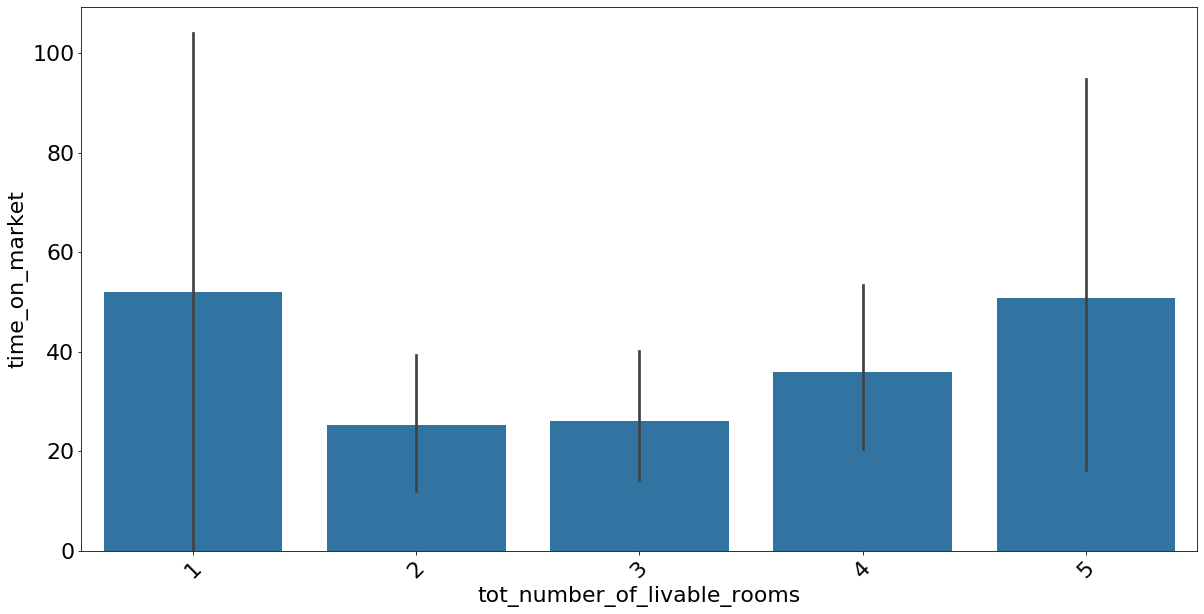

In [41]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["font.size"] = 22
sns.barplot(data=df_sold, x="tot_number_of_livable_rooms", y="time_on_market", color="C0")
_= plt.xticks(rotation=45)

In [42]:
time_on_market_by_property_type = df_sold.groupby(['property_type']).time_on_market.median().reset_index()
time_on_market_by_property_type

,property_type,time_on_market
0,Apartment,56.0
1,Appartamento,5.0
2,Casa indipendente,10.5
3,House,45.0
4,Villa,9.0


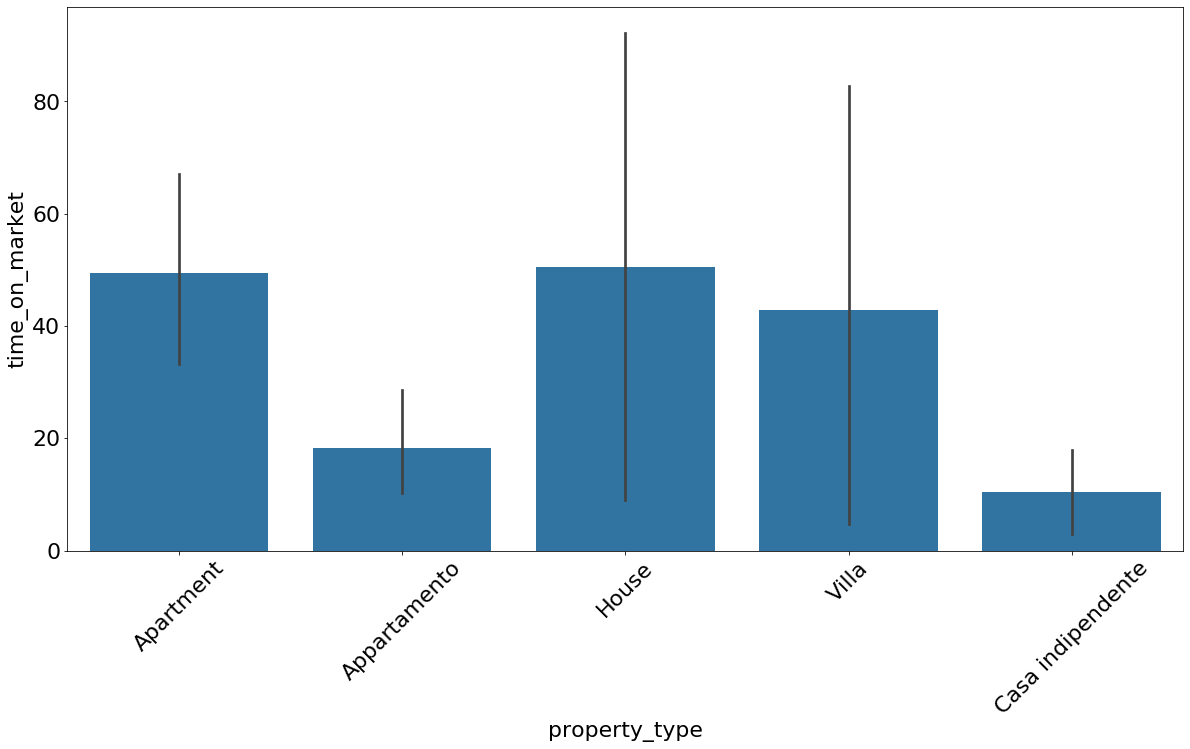

In [43]:
# sns.barplot(data=time_on_market_by_property_type, x="property_type", y="time_on_market", color="C0")
ax = sns.barplot(data=df_sold, x="property_type", y="time_on_market", color="C0")
_= plt.xticks(rotation=45)

In [48]:
from scipy import stats
import statsmodels.api as sm

slope = 0.20553099890186302
intercept = 10.452448825007075
for each extra sqm, the time on market increase by 0.21 days


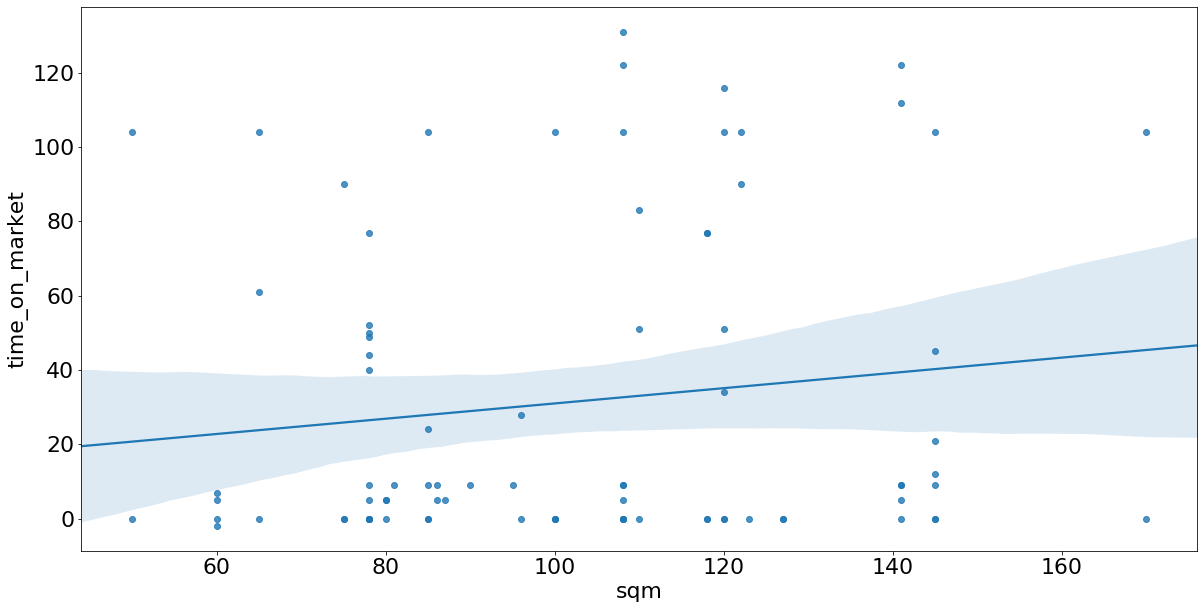

In [60]:
Y = df_sold.time_on_market
X = df_sold.sqm

slope, intercept, r_value, p_value, slope_std_error = stats.linregress(X,Y)
predict_y = slope * X + intercept

print("slope = " + str(slope))
print("intercept = " + str(intercept))

sns.regplot(x=X, y=Y, fit_reg=True)
# sns.regplot(x=X, y=predict_y,scatter=False)

print("for each extra sqm, the time on market increase by {:.2f} days".format(slope))

In [63]:
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         time_on_market   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.629
Date:                Wed, 05 Feb 2020   Prob (F-statistic):              0.205
Time:                        11:27:22   Log-Likelihood:                -447.17
No. Observations:                  87   AIC:                             898.3
Df Residuals:                      85   BIC:                             903.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4524     17.073      0.612      0.542     -23.494      44.399
sqm            0.2055      0.161      1.276      0.205      -0.115       0.526
==============================================================================
Omnibus:                       13.620   Durbin-Watson:                   0.368
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.234
Skew:                           0.987   Prob(JB):                     0.000492
Kurtosis:                       2.445   Cond. No.                         404.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpreting the Table** Df of residuals and models relates to the degrees of freedom — “the number of values in the final calculation of a statistic that are free to vary.”

A R-squared value of 0.019, means that the model is able to explain only 1.9% of the variance in our dependent variable 

The coefficient of 0.3007 for `sqm` means that when the variable increases by 1, the predicted value of `time_on_market` increases by 0.3007 (decreases). A few other important values are the standard error (is the standard deviation of the sampling distribution of a statistic, most commonly of the mean); the t scores and p-values, for hypothesis test — the `time_on_market` has statistically significant p-value for `sqm` and `tot_number_of_livable_rooms`; there is a 95% confidence intervals for the `sqm` for example (meaning we predict at a 95% percent confidence that the value of RM is between -0.130 to -0.041).

slope = -1.0074910800373805e-06
intercept = 32.0124459211443
for each extra 10,000 Euro asked, the time on market increase by -0.01 days


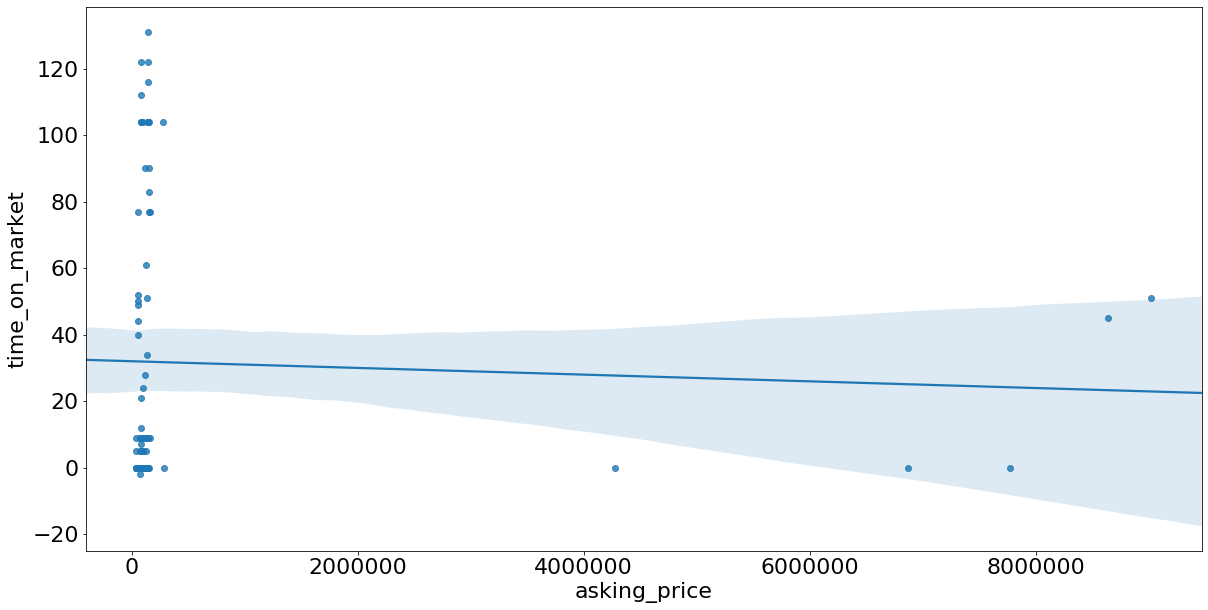

In [66]:
Y = df_sold.time_on_market
X = df_sold.asking_price

slope, intercept, r_value, p_value, slope_std_error = stats.linregress(X,Y)
# predict_y = slope * X + intercept

print("slope = " + str(slope))
print("intercept = " + str(intercept))

sns.regplot(x=X, y=Y, fit_reg=True)
# sns.regplot(x=X, y=predict_y,scatter=False)

print("for each extra 10,000 Euro asked, the time on market increase by {:.2f} days".format(slope * 10000))

In [67]:
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         time_on_market   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.1481
Date:                Wed, 05 Feb 2020   Prob (F-statistic):              0.701
Time:                        11:28:01   Log-Likelihood:                -447.92
No. Observations:                  87   AIC:                             899.8
Df Residuals:                      85   BIC:                             904.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           32.0124      4.724      6.777      0.000      22.621      41.404
asking_price -1.007e-06   2.62e-06     -0.385      0.701   -6.21e-06     4.2e-06
==============================================================================
Omnibus:                       14.210   Durbin-Watson:                   0.340
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.333
Skew:                           1.028   Prob(JB):                     0.000284
Kurtosis:                       2.473   Cond. No.                     1.89e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [68]:
df.columns

Index(['id', 'url', 'scraped_at', 'lat', 'lon', 'distance', 'city',
       'municipality', 'sqm', 'asking_price', 'property_type',
       'tot_number_of_livable_rooms', 'tot_number_of_bathrooms', 'last_seen',
       'is_gone', 'has_new_entry', 'time_on_market'],
      dtype='object')

In [70]:
X = df_sold[['sqm', 'asking_price', 'tot_number_of_livable_rooms', 'tot_number_of_bathrooms']]
Y = df_sold['time_on_market']
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) # make the predictions by the model


# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         time_on_market   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.8841
Date:                Wed, 05 Feb 2020   Prob (F-statistic):              0.477
Time:                        11:37:52   Log-Likelihood:                -446.16
No. Observations:                  87   AIC:                             902.3
Df Residuals:                      82   BIC:                             914.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           3.3080     18.111      0.183      0.856     -32.720      39.336
sqm                             0.1661      0.322      0.516      0.607      -0.474       0.806
asking_price                 -1.08e-06   2.76e-06     -0.391      0.697   -6.58e-06    4.42e-06
tot_number_of_livable_rooms    -0.6016      9.263     -0.065      0.948     -19.029      17.825
tot_number_of_bathrooms        10.5375      8.502      1.239      0.219      -6.375      27.450
==============================================================================
Omnibus:                       12.690   Durbin-Watson:                   0.390
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.333
Skew:                           0.908   Prob(JB):                      0.00127
Kurtosis:                       2.383   Cond. No.                     7.34e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpreting the Table** First we have what’s the dependent variable and the model and the method. OLS stands for Ordinary Least Squares and the method “Least Squares” means that we’re trying to fit a regression line that would minimize the square of distance from the regression line. Date and Time are pretty self-explanatory :) So as number of observations. Df of residuals and models relates to the degrees of freedom — “the number of values in the final calculation of a statistic that are free to vary.”

A R-squared value of 0.041, means that the model is able to explain only 4.1% of the variance in our dependent variable 

The coefficient of 0.1661 for `sqm` means that when the variable increases by 1, the predicted value of `time_on_market` increases by 0.1661. A few other important values are the standard error (is the standard deviation of the sampling distribution of a statistic, most commonly of the mean); the t scores and p-values, for hypothesis test — the `time_on_market` has statistically significant p-value for `sqm` and `tot_number_of_livable_rooms`; there is a 95% confidence intervals for the `sqm` for example (meaning we predict at a 95% percent confidence that the value of RM is between -0.130 to -0.041).

In [ ]:
time_series_query = """

WITH base as (
select 
    id
    , identity.url
    , identity.download_data as scraped_at
    , geography.gps.lat as lat
    , geography.gps.lon as lon
    , round(ST_DISTANCE(ST_GEOGPOINT(geography.gps.lon, geography.gps.lat), ST_GEOGPOINT(8.9617242, 45.5552881)), 2) as distance
    , geography.address.city as city
    , geography.address.municipality as municipality
    , area.internal.sqm as sqm
    , price.amount as asking_price
    , features.type_of as property_type
    , features.living_room_no as tot_number_of_livable_rooms
    , features.bath_room_no as tot_number_of_bathrooms
    , last_seen
    , CONCAT(EXTRACT(YEAR FROM identity.download_data), "-",EXTRACT(WEEK FROM identity.download_data)) as week
    , COALESCE(is_gone, FALSE) as is_gone
    , COALESCE(has_new_entry, FALSE) as has_new_entry
--     , TIMESTAMP_DIFF(last_seen, identity.download_data, DAY) as time_on_market

from `viper-uk.data_it.data_asking` asking
    left join `viper-uk.data_it.missing_props` mp on asking.identity.url = mp.url and asking.identity.download_data = mp.last_seen
where 
--     last_seen > "2020-02-01 00:00:00 UTC" and 
--     ST_DISTANCE(ST_GEOGPOINT(geography.gps.lon, geography.gps.lat), ST_GEOGPOINT(8.9617242, 45.5552881)) < 10000
    identity.url in ( "https://www.immobiliare.it/annunci/75635576/", "https://www.casa.it/appartamento/vendita/milano/bettinetti-7-rho-90mq-38088836/", "https://www.immobiliare.it/annunci/76721028/")
)

, weeks AS (
  SELECT distinct url, CONCAT(EXTRACT(YEAR FROM day), "-",EXTRACT(WEEK FROM day)) as week 
  FROM (
    SELECT url, 
      MIN(DATE(scraped_at)) min_dt, 
      MAX(DATE(last_seen)) max_dt
    FROM base group by url
  ), UNNEST(GENERATE_DATE_ARRAY(min_dt, max_dt, INTERVAL 1 WEEK )) day
)

-- select * from weeks

select w.url, w.week, --b.asking_price, b.is_gone
LAST_VALUE(b.is_gone IGNORE NULLS) OVER(ORDER BY w.url, w.week) is_gone,
  LAST_VALUE(b.asking_price IGNORE NULLS) OVER(ORDER BY w.url, w.week) asking_price
FROM weeks w 
LEFT JOIN base b
ON w.week = b.week and w.url=b.url
ORDER BY w.url, w.week  
 


-- , a as (
-- SELECT 
--   FIRST_VALUE(id IGNORE NULLS) over w1 as id
-- , FIRST_VALUE(base.url IGNORE NULLS) over w1 as url
-- , FIRST_VALUE(scraped_at IGNORE NULLS) over w1 as first_scraped_at
-- , LAST_VALUE(scraped_at IGNORE NULLS) over w1 as last_scraped_at
-- , FIRST_VALUE(lat IGNORE NULLS) over w1 as lat
-- , FIRST_VALUE(lon IGNORE NULLS) over w1 as lon
-- , FIRST_VALUE(distance IGNORE NULLS) over w1 as distance
-- , FIRST_VALUE(city IGNORE NULLS) over w1 as city
-- , FIRST_VALUE(municipality IGNORE NULLS) over w1 as municipality
-- , FIRST_VALUE(sqm IGNORE NULLS) over w1 as sqm
-- , FIRST_VALUE(asking_price IGNORE NULLS) over w1 as initial_asking_price
-- , LAST_VALUE(asking_price IGNORE NULLS) over w1 as final_asking_price
-- -- , ARRAY_AGG(asking_price) over w1 as all_asking_prices
-- , FIRST_VALUE(property_type IGNORE NULLS) over w1 as property_type
-- , FIRST_VALUE(tot_number_of_livable_rooms IGNORE NULLS) over w1 as tot_number_of_livable_rooms
-- , FIRST_VALUE(tot_number_of_bathrooms IGNORE NULLS) over w1 as tot_number_of_bathrooms
-- , FIRST_VALUE(last_seen IGNORE NULLS) over w1 as first_seen
-- , LAST_VALUE(last_seen IGNORE NULLS) over w1 as last_seen 
-- , LAST_VALUE(is_gone IGNORE NULLS) over w1 as is_gone
-- -- , LAST_VALUE(has_new_entry) over w1 as has_new_entry
-- , TIMESTAMP_DIFF(LAST_VALUE(last_seen IGNORE NULLS) OVER w1, FIRST_VALUE(scraped_at IGNORE NULLS) OVER w1, DAY) as time_on_market
-- FROM weeks left join base ON weeks.week = base.week and weeks.url=base.url
-- WINDOW w1 AS (PARTITION BY base.url ORDER BY scraped_at ASC ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
-- )

-- -- select url, count(*) from base group by url having COUNT(*)>1
-- select * from a 



-- select * from `viper-uk.data_it.missing_props` 
-- where url = "https://www.immobiliare.it/annunci/75635576/"

-- WITH your_current_result AS (
--   SELECT '2017-07-21T00:00:00Z' ProgressDate, 0.125 EstMin, 0.25 EstMax UNION ALL
--   SELECT '2017-07-24T00:00:00Z', 5.125, 5.375 UNION ALL
--   SELECT '2017-07-25T00:00:00Z', 8.75, 10.25 UNION ALL
--   SELECT '2017-07-26T00:00:00Z', 10.0, 12.0 UNION ALL
--   SELECT '2017-07-27T00:00:00Z', 10.5, 12.75 UNION ALL
--   SELECT '2017-08-01T00:00:00Z', 15.25, 19.125 UNION ALL
--   SELECT '2017-08-02T00:00:00Z', 15.5, 19.375 UNION ALL
--   SELECT '2017-08-05T00:00:00Z', 16.25, 20.625 
-- )


-- , days AS (
--   SELECT day
--   FROM (
--     SELECT 
--       MIN(DATE(TIMESTAMP(ProgressDate))) min_dt, 
--       MAX(DATE(TIMESTAMP(ProgressDate))) max_dt
--     FROM your_current_result
--   ), UNNEST(GENERATE_DATE_ARRAY(min_dt, max_dt)) day
-- )

-- select * from days

-- select GENERATE_DATE_ARRAY("2017-07-21", "2017-08-05")
-- select distinct CONCAT(EXTRACT(YEAR FROM day), "-",EXTRACT(WEEK FROM day)) as week from UNNEST(GENERATE_DATE_ARRAY("2017-07-21", "2017-08-05", INTERVAL 1 WEEK )) day
-- select day from UNNEST(GENERATE_DATE_ARRAY("2017-07-21", "2017-08-05" , INTERVAL 1 WEEK )) day

-- SELECT day, 
--   LAST_VALUE(EstMin IGNORE NULLS) OVER(ORDER BY day) EstMin,
--   LAST_VALUE(EstMax IGNORE NULLS) OVER(ORDER BY day) EstMax
-- FROM days
-- LEFT JOIN your_current_result
-- ON day = DATE(TIMESTAMP(ProgressDate))
-- ORDER BY day  
"""